In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import zipfile
import random
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, LSTM, GRU, SimpleRNN, Bidirectional, Reshape, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Setting seeds for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Libraries imported.")

Libraries imported.


In [2]:
zip_path = 'Handwritten PDF SS.zip' 
extract_path = './extracted_dataset'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20 

# Unzipping Data
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted.")

# Defining Paths
original_dir = os.path.join(extract_path, 'Handwritten PDF SS/Original') 
ai_generated_dir = os.path.join(extract_path, 'Handwritten PDF SS/AI Generated')

data = []
labels = []

def load_images(folder, label):
    count = 0
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)
                img = img.astype('float32') / 255.0
                img = np.expand_dims(img, axis=-1)
                data.append(img)
                labels.append(label)
                count += 1
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    return count

print("Loading images...")
c1 = load_images(original_dir, 0) # 0 for Original
c2 = load_images(ai_generated_dir, 1) # 1 for AI

X = np.array(data)
y = np.array(labels)

print(f"Loaded {len(X)} images. Shape: {X.shape}")

Loading images...
Loaded 500 images. Shape: (500, 128, 128, 1)


In [3]:
def build_model(model_type):
    inputs = Input(shape=(128, 128, 1))
    
    if model_type == 'CNN':
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        x = MaxPooling2D((2, 2))(x)
        x = BatchNormalization()(x)
        
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = BatchNormalization()(x)
        
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.3)(x)
        
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.4)(x)
        outputs = Dense(1, activation='sigmoid')(x)
        
    else:
        # Reshaping for RNNs: (128, 128, 1) -> (128, 128)
        x = Reshape((128, 128))(inputs)
        
        if model_type == 'LSTM':
            x = LSTM(128, return_sequences=False)(x)
        elif model_type == 'Bi-LSTM':
            x = Bidirectional(LSTM(64, return_sequences=False))(x)
        elif model_type == 'GRU':
            x = GRU(128, return_sequences=False)(x)
        elif model_type == 'SimpleRNN':
            x = SimpleRNN(128, return_sequences=False)(x)
            
        x = Dropout(0.4)(x)
        x = Dense(64, activation='relu')(x)
        outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs, name=model_type)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model_names = ['CNN', 'LSTM', 'Bi-LSTM', 'GRU', 'SimpleRNN']

In [4]:
# Defining 5-Fold Stratified Cross-Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Dictionary to store aggregated results for final plotting
final_results = {}

for name in model_names:
    print(f"\n{'='*40}")
    print(f"Evaluating Model: {name} using 5-Fold CV")
    print(f"{'='*40}")
    
    # Lists to store metrics per fold
    fold_tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    fold_aucs = []
    
    # Storing true labels and predicted probs for global confusion matrix
    aggregated_y_true = []
    aggregated_y_pred_probs = []
    
    fold_no = 1
    for train_ix, val_ix in kfold.split(X, y):
        # Splitting data
        X_train, X_val = X[train_ix], X[val_ix]
        y_train, y_val = y[train_ix], y[val_ix]
        
        # Generators
        train_datagen = ImageDataGenerator(
            rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
            zoom_range=0.1, shear_range=0.1, fill_mode="nearest"
        )
        val_datagen = ImageDataGenerator() # No augmentation for validation
        
        train_gen = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
        val_gen = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)
        
        # Building fresh model
        model = build_model(name)
        
        # Training
        print(f"  Training Fold {fold_no}/5...")
        model.fit(train_gen, epochs=EPOCHS, verbose=0) # verbose = 0 to reduce clutter
        
        # Prediction
        y_pred_prob = model.predict(val_gen, verbose=0).ravel()
        
        # ROC Calculations for this fold
        fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
        # Interpolating TPR to base FPR so we can average later
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        fold_tprs.append(interp_tpr)
        fold_aucs.append(auc(fpr, tpr))
        
        # Aggregating Data for Confusion Matrix
        aggregated_y_true.extend(y_val)
        aggregated_y_pred_probs.extend(y_pred_prob)
        
        fold_no += 1

    # Processing Aggregated Results for this Model
    mean_tpr = np.mean(fold_tprs, axis=0)
    mean_tpr[-1] = 1.0 # Ensuring curve ends at 1,1
    mean_auc = auc(mean_fpr, mean_tpr)
    
    # Converting aggregated probs to binary predictions
    aggregated_y_pred = (np.array(aggregated_y_pred_probs) > 0.5).astype(int)
    
    final_results[name] = {
        'mean_fpr': mean_fpr,
        'mean_tpr': mean_tpr,
        'mean_auc': mean_auc,
        'y_true': np.array(aggregated_y_true),
        'y_pred_prob_raw': aggregated_y_pred_probs,
        'y_pred': (np.array(aggregated_y_pred_probs) > 0.5).astype(int)
    }
    
    print(f"  -> Done. Mean AUC: {mean_auc:.4f}")


Evaluating Model: CNN using 5-Fold CV
  Training Fold 1/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 2/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 3/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 4/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 5/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  -> Done. Mean AUC: 0.8855

Evaluating Model: LSTM using 5-Fold CV
  Training Fold 1/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 2/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 3/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 4/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 5/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  -> Done. Mean AUC: 0.5209

Evaluating Model: Bi-LSTM using 5-Fold CV
  Training Fold 1/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 2/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 3/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 4/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 5/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  -> Done. Mean AUC: 0.5936

Evaluating Model: GRU using 5-Fold CV
  Training Fold 1/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 2/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 3/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 4/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 5/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  -> Done. Mean AUC: 0.4872

Evaluating Model: SimpleRNN using 5-Fold CV
  Training Fold 1/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 2/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 3/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 4/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Training Fold 5/5...


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  -> Done. Mean AUC: 0.5660


Model: CNN | Best Threshold: 0.9983


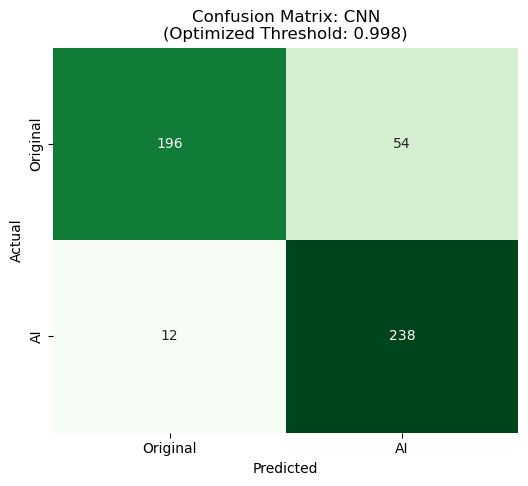

              precision    recall  f1-score   support

    Original       0.94      0.78      0.86       250
          AI       0.82      0.95      0.88       250

    accuracy                           0.87       500
   macro avg       0.88      0.87      0.87       500
weighted avg       0.88      0.87      0.87       500

------------------------------------------------------------
Model: LSTM | Best Threshold: 0.5039


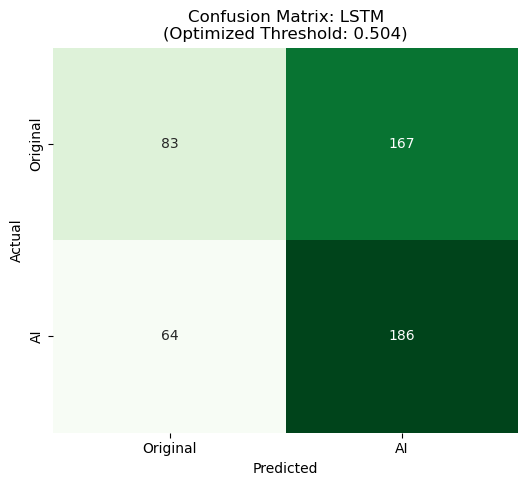

              precision    recall  f1-score   support

    Original       0.56      0.33      0.42       250
          AI       0.53      0.74      0.62       250

    accuracy                           0.54       500
   macro avg       0.55      0.54      0.52       500
weighted avg       0.55      0.54      0.52       500

------------------------------------------------------------
Model: Bi-LSTM | Best Threshold: 0.4984


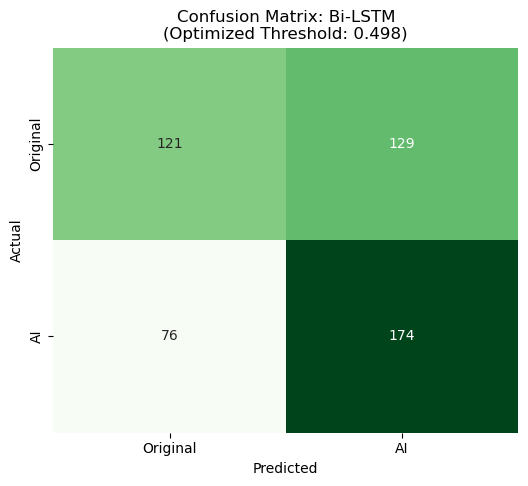

              precision    recall  f1-score   support

    Original       0.61      0.48      0.54       250
          AI       0.57      0.70      0.63       250

    accuracy                           0.59       500
   macro avg       0.59      0.59      0.59       500
weighted avg       0.59      0.59      0.59       500

------------------------------------------------------------
Model: GRU | Best Threshold: 0.4780


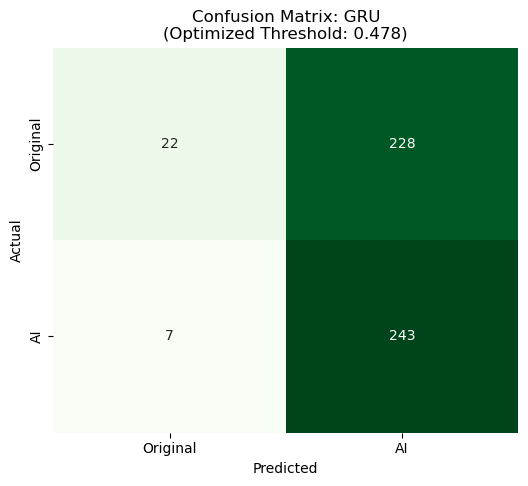

              precision    recall  f1-score   support

    Original       0.76      0.09      0.16       250
          AI       0.52      0.97      0.67       250

    accuracy                           0.53       500
   macro avg       0.64      0.53      0.42       500
weighted avg       0.64      0.53      0.42       500

------------------------------------------------------------
Model: SimpleRNN | Best Threshold: 0.5044


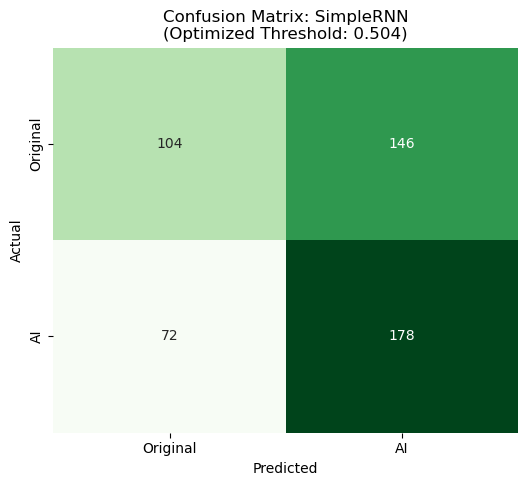

              precision    recall  f1-score   support

    Original       0.59      0.42      0.49       250
          AI       0.55      0.71      0.62       250

    accuracy                           0.56       500
   macro avg       0.57      0.56      0.55       500
weighted avg       0.57      0.56      0.55       500

------------------------------------------------------------


In [5]:
best_thresholds = {}

for name in model_names:
    res = final_results[name]
    
    # Calculating Youden's J statistic to find the optimal threshold
    # J = Sensitivity + Specificity - 1
    # J = TPR + (1 - FPR) - 1  =>  J = TPR - FPR
    fpr = res['mean_fpr']
    tpr = res['mean_tpr']
    
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = res['mean_fpr'][ix] # This maps index to FPR, we need the threshold from the original curve
    
    # Since we interpolated the TPR/FPR in the loop, we can't get the exact threshold back easily from the mean curve.
    # Instead, we recalculate the ROC on the AGGREGATED predictions to find the precise threshold.
    
    agg_fpr, agg_tpr, agg_thresholds = roc_curve(res['y_true'], final_results[name]['y_pred_prob_raw']) 
    
    J_agg = agg_tpr - agg_fpr
    ix_agg = np.argmax(J_agg)
    best_thresh = agg_thresholds[ix_agg]
    
    best_thresholds[name] = best_thresh
    print(f"Model: {name} | Best Threshold: {best_thresh:.4f}")

    # Recalculating Confusion Matrix with new Threshold
    # Applying the new threshold to the raw probabilities
    new_preds = (np.array(final_results[name]['y_pred_prob_raw']) > best_thresh).astype(int)
    
    cm = confusion_matrix(res['y_true'], new_preds)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=['Original', 'AI'], yticklabels=['Original', 'AI'])
    plt.title(f'Confusion Matrix: {name}\n(Optimized Threshold: {best_thresh:.3f})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    print(classification_report(res['y_true'], new_preds, target_names=['Original', 'AI']))
    print("-" * 60)

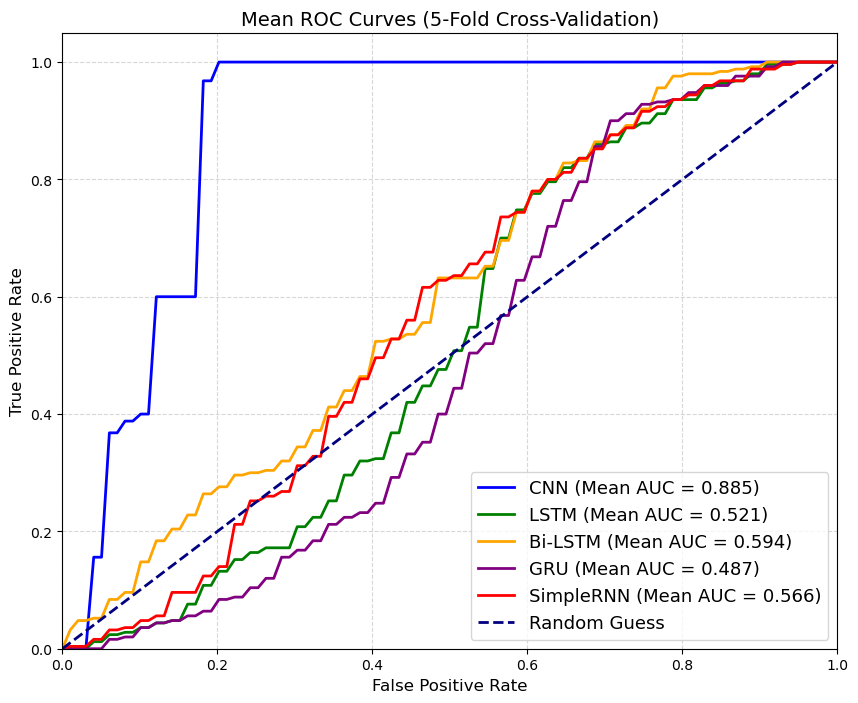

In [17]:
plt.figure(figsize=(10, 8))
colors = {'CNN': 'blue', 'LSTM': 'green', 'Bi-LSTM': 'orange', 'GRU': 'purple', 'SimpleRNN': 'red'}

for name in model_names:
    res = final_results[name]
    plt.plot(res['mean_fpr'], res['mean_tpr'], color=colors.get(name, 'black'), lw=2, 
             label=f'{name} (Mean AUC = {res["mean_auc"]:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Mean ROC Curves (5-Fold Cross-Validation)', fontsize=14)
plt.legend(loc="lower right", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()